# Import Libraries and Load New Dataset

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
import shap

# Load data
train = pd.read_csv('../data/new_train.csv')
print("Shape of train:", train.shape)
train.head()
print(list(train.columns))

Shape of train: (1460, 203)
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'LandContour_HLS', 'LandCon

# Select Features

In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import root_mean_squared_error
import shap

# Load data
train = pd.read_csv('../data/new_train.csv')

# Drop 'Id' if present
if 'Id' in train.columns:
    train.drop(columns=['Id'], inplace=True)

# Separate target and features
y = train['SalePrice']
X = train.drop(columns=['SalePrice'])

# Step 1: Pearson Correlation for Numerical Features
correlation_threshold = 0.2
correlation_matrix = X.corrwith(y)
num_high_corr_features = correlation_matrix[abs(correlation_matrix) > correlation_threshold].index.tolist()

# Step 2: Keep only highly correlated features
selected_features = list(set(num_high_corr_features))

# Update X to include only selected features
X = X[selected_features]

# Split into Train (80%) and Dev (20%)
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)

# Train initial XGBoost model
initial_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
initial_xgb_model.fit(X_train, y_train)

# Get Feature Importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': initial_xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Keep the top 40 features
top_features = feature_importances.head(40)['Feature'].tolist()

# Step 4: Recursive Feature Elimination (RFE) to Further Reduce Features
rfe_selector = RFE(estimator=initial_xgb_model, n_features_to_select=30, step=1)
rfe_selector.fit(X_train[top_features], y_train)

rfe_selected_features = [feature for feature, selected in zip(top_features, rfe_selector.support_) if selected]

# Filter X_train and X_dev to only RFE-selected features
X_train_rfe = X_train[rfe_selected_features]
X_dev_rfe = X_dev[rfe_selected_features]

# **Re-train XGBoost model with RFE-selected features**
final_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
final_xgb_model.fit(X_train_rfe, y_train)

# Debugging Step 1: Print Feature Mismatch Before SHAP
print("\n--- Feature Debugging Before SHAP ---")
print("Train Features (X_train):", list(X_train_rfe.columns))
print("Dev Features (X_dev):", list(X_dev_rfe.columns))
print("RFE Selected Features:", rfe_selected_features)

# Step 5: SHAP Analysis - Ensure exact feature alignment
explainer = shap.Explainer(lambda x: final_xgb_model.predict(pd.DataFrame(x, columns=X_dev_rfe.columns)), X_dev_rfe, algorithm="permutation")
shap_values = explainer(X_dev_rfe)

# Calculate SHAP importance
shap_importance = pd.DataFrame({'Feature': rfe_selected_features, 'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)})
shap_importance = shap_importance.sort_values(by='SHAP_Importance', ascending=False)

# Keep the top 25 most influential features based on SHAP
final_selected_features = shap_importance.head(25)['Feature'].tolist()

# Evaluate Final Model
y_pred_final = final_xgb_model.predict(X_dev_rfe)
final_rmse = root_mean_squared_error(y_dev, y_pred_final)

print(f"\nFinal RMSE: {final_rmse}")
print("Final Selected Features:", final_selected_features)



--- Feature Debugging Before SHAP ---
Train Features (X_train): ['Qual_LivArea_Interaction', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalSF', 'HouseAge', 'GarageFinish', 'MSZoning_RM', 'KitchenQual', 'TotalBsmtSF', 'BsmtFinSF1', 'YearBuilt', 'CentralAir', '2ndFlrSF', '1stFlrSF', 'RemodAge', 'TotalBath', 'OpenPorchSF', 'lot_frontage_lot_area', 'MSZoning_RL', 'FireplaceQu', 'BsmtFinType1', 'ExterQual', 'GarageQual', 'YearRemodAdd', 'LotArea', 'BsmtCond', 'GarageCond', 'SaleType_New', 'BsmtExposure']
Dev Features (X_dev): ['Qual_LivArea_Interaction', 'OverallQual', 'BsmtQual', 'GarageCars', 'TotalSF', 'HouseAge', 'GarageFinish', 'MSZoning_RM', 'KitchenQual', 'TotalBsmtSF', 'BsmtFinSF1', 'YearBuilt', 'CentralAir', '2ndFlrSF', '1stFlrSF', 'RemodAge', 'TotalBath', 'OpenPorchSF', 'lot_frontage_lot_area', 'MSZoning_RL', 'FireplaceQu', 'BsmtFinType1', 'ExterQual', 'GarageQual', 'YearRemodAdd', 'LotArea', 'BsmtCond', 'GarageCond', 'SaleType_New', 'BsmtExposure']
RFE Selected Features: ['Qual

PermutationExplainer explainer: 293it [00:28,  7.19it/s]                         


Final RMSE: 28395.841796875
Final Selected Features: ['Qual_LivArea_Interaction', 'TotalSF', 'BsmtFinSF1', 'OverallQual', 'TotalBsmtSF', 'FireplaceQu', 'HouseAge', 'GarageCars', 'TotalBath', 'RemodAge', 'KitchenQual', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtQual', 'GarageFinish', 'BsmtFinType1', 'lot_frontage_lot_area', 'BsmtExposure', 'ExterQual', '1stFlrSF', 'MSZoning_RM', '2ndFlrSF', 'OpenPorchSF', 'BsmtCond']


In [3]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import shap

# Load data
train = pd.read_csv('../data/new_train.csv')

# Drop 'Id' if present
if 'Id' in train.columns:
    train.drop(columns=['Id'], inplace=True)

# Separate target and features
y = train['SalePrice']
X = train.drop(columns=['SalePrice'])

# Split into Train (80%) and Dev (20%)
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=36)

# Train initial XGBoost model on all features
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=36)
xgb_model.fit(X_train, y_train)

# Step 1: Get Feature Importances from XGBoost
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Step 2: Keep the top 40 features based on XGBoost feature importance
top_features = feature_importances.head(40)['Feature'].tolist()

# Step 3: Train XGBoost with only the top features
X_train_top = X_train[top_features]
X_dev_top = X_dev[top_features]

xgb_model_top = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=36)
xgb_model_top.fit(X_train_top, y_train)

# Step 4: SHAP Analysis
explainer = shap.Explainer(lambda x: xgb_model_top.predict(pd.DataFrame(x, columns=X_dev_top.columns)), X_dev_top, algorithm="permutation")
shap_values = explainer(X_dev_top)

# Step 5: Calculate SHAP importance
shap_importance = pd.DataFrame({'Feature': top_features, 'SHAP_Importance': np.abs(shap_values.values).mean(axis=0)})
shap_importance = shap_importance.sort_values(by='SHAP_Importance', ascending=False)

# Step 6: Keep the top 25 most influential features based on SHAP
final_selected_features = shap_importance.head(30)['Feature'].tolist()

# Step 7: Retrain Final XGBoost Model with Selected Features
X_train_final = X_train[final_selected_features]
X_dev_final = X_dev[final_selected_features]

xgb_final_model = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_final_model.fit(X_train_final, y_train)

# Step 8: Evaluate Final Model
y_pred_final = xgb_final_model.predict(X_dev_final)
final_rmse = root_mean_squared_error(y_dev, y_pred_final)

print(f"\nFinal RMSE: {final_rmse}")
print("Final Selected Features:", final_selected_features)


PermutationExplainer explainer: 293it [00:26,  6.92it/s]                         



Final RMSE: 28341.126953125
Final Selected Features: ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', '1stFlrSF', 'BsmtFullBath', 'HouseAge', 'CentralAir', 'Neighborhood_Crawfor', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Neighborhood_OldTown']


In [4]:
selected_features = ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', 'BsmtFullBath', '1stFlrSF', 'HouseAge', 'Neighborhood_Crawfor', 'CentralAir', 'KitchenAbvGr', 'Neighborhood_OldTown', 'TotRmsAbvGrd']
target = "SalePrice"

all_cols_needed = selected_features + [target]
df = train[all_cols_needed].copy()

print("Columns in use:\n", df.columns.tolist())
df.head()


Columns in use:
 ['Qual_LivArea_Interaction', 'TotalSF', 'TotalBsmtSF', 'BsmtFinSF1', 'RemodAge', 'OverallQual', 'KitchenQual', 'BsmtQual', 'YearBuilt', 'GarageCars', 'BsmtExposure', 'GarageFinish', 'OpenPorchSF', 'ExterQual', 'FireplaceQu', 'GarageAge', 'TotalBath', '2ndFlrSF', 'BsmtFinType1', 'Fireplaces', 'Functional', 'MSZoning_RL', 'BsmtFullBath', '1stFlrSF', 'HouseAge', 'Neighborhood_Crawfor', 'CentralAir', 'KitchenAbvGr', 'Neighborhood_OldTown', 'TotRmsAbvGrd', 'SalePrice']


,Qual_LivArea_Interaction,TotalSF,TotalBsmtSF,BsmtFinSF1,RemodAge,OverallQual,KitchenQual,BsmtQual,YearBuilt,GarageCars,...,MSZoning_RL,BsmtFullBath,1stFlrSF,HouseAge,Neighborhood_Crawfor,CentralAir,KitchenAbvGr,Neighborhood_OldTown,TotRmsAbvGrd,SalePrice
0,11970,2566,856,706,5,7,3,4,2003,2,...,1,1,856,5,0,1,1,0,8,208500
1,7572,2524,1262,978,31,6,2,4,1976,2,...,1,0,1262,31,0,1,1,0,6,181500
2,12502,2706,920,486,6,7,3,4,2001,2,...,1,1,920,7,0,1,1,0,6,223500
3,12019,2473,756,216,36,7,3,3,1915,3,...,1,1,961,91,1,1,1,0,7,140000
4,17584,3343,1145,655,8,8,3,4,2000,3,...,1,1,1145,8,0,1,1,0,9,250000


# Define features and target

In [5]:
X = df[selected_features]
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1460, 30)
y shape: (1460,)


# Split Train and Dev Set

In [6]:
X_train, X_dev, y_train, y_dev = train_test_split(
    X, y, test_size=0.2, random_state=36
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Dev shapes:", X_dev.shape, y_dev.shape)


Train shapes: (1168, 30) (1168,)
Dev shapes: (292, 30) (292,)


# Train XGBoost

In [7]:
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=10,
    reg_lambda=10,
    gamma=5,
    random_state=36,
    early_stopping_rounds=50
)

model.fit(
    X_train, y_train,
    eval_set=[(X_dev, y_dev)],
    verbose=10
)

# Predict and evaluate
y_train_pred = model.predict(X_train)
y_dev_pred = model.predict(X_dev)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
dev_rmse = root_mean_squared_error(y_dev, y_dev_pred)

print(f"Train RMSE: {train_rmse:,.0f}")
print(f"Dev RMSE: {dev_rmse:,.0f}")

[0]	validation_0-rmse:82845.78146
[10]	validation_0-rmse:73603.04653
[20]	validation_0-rmse:65788.54594
[30]	validation_0-rmse:59163.50086
[40]	validation_0-rmse:53553.65871
[50]	validation_0-rmse:49003.63905
[60]	validation_0-rmse:45252.47536
[70]	validation_0-rmse:42103.21119
[80]	validation_0-rmse:39474.57911
[90]	validation_0-rmse:37373.14143
[100]	validation_0-rmse:35724.79536
[110]	validation_0-rmse:34321.23405
[120]	validation_0-rmse:33158.77570
[130]	validation_0-rmse:32251.34196
[140]	validation_0-rmse:31315.06387
[150]	validation_0-rmse:30665.34020
[160]	validation_0-rmse:30111.95908
[170]	validation_0-rmse:29634.38821
[180]	validation_0-rmse:29123.39445
[190]	validation_0-rmse:28783.60686
[200]	validation_0-rmse:28552.07343
[210]	validation_0-rmse:28359.05252
[220]	validation_0-rmse:28123.82049
[230]	validation_0-rmse:27904.33852
[240]	validation_0-rmse:27685.34294
[250]	validation_0-rmse:27547.64936
[260]	validation_0-rmse:27385.84289
[270]	validation_0-rmse:27296.19119
[28

# Residual Analysis

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute residuals: actual - predicted
residuals = y_dev - y_dev_pred
df_res = pd.DataFrame({
    'Actual': y_dev,
    'Predicted': y_dev_pred,
    'Residual': residuals
})
df_res.head(10)


,Actual,Predicted,Residual
1057,248000,215383.687500,32616.312500
1391,124000,143020.484375,-19020.484375
291,135900,135954.062500,-54.062500
226,290000,282666.125000,7333.875000
622,135000,127640.195312,7359.804688
514,96500,105630.437500,-9130.437500
1383,112000,133872.546875,-21872.546875
524,315750,288117.812500,27632.187500
145,130000,174088.828125,-44088.828125
209,145000,144037.234375,962.765625


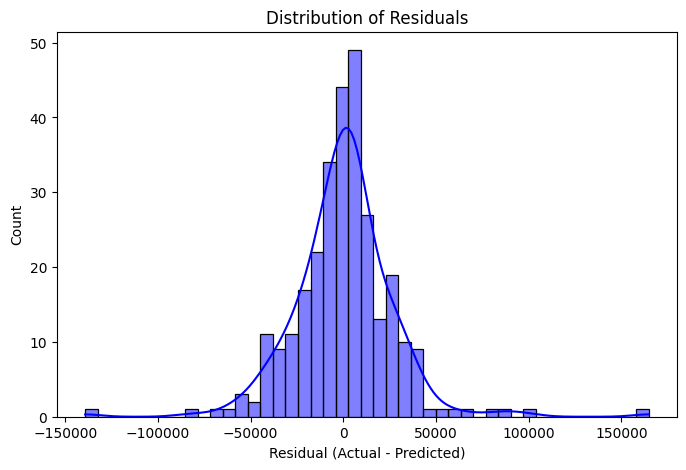

In [9]:
# Distribution of Residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.show()


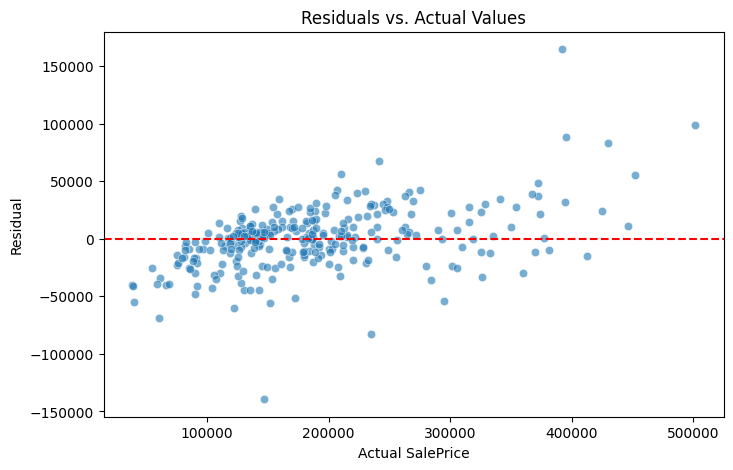

In [10]:
# Residuals vs. Actual
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_dev, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual Values')
plt.xlabel('Actual SalePrice')
plt.ylabel('Residual')
plt.show()


# Load and Predict on Test Dataset

In [14]:
test = pd.read_csv('../data/new_test.csv')
test_ids = test['Id']
test = test[list(X_train.columns)]
y_test_pred = model.predict(test)
submission = pd.DataFrame({'Id': test_ids, 'SalePrice': y_test_pred})
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'. Ready for Kaggle upload!")

Submission file saved as 'submission.csv'. Ready for Kaggle upload!
